In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import geopandas as gpd
import earthpy as et
import xarray as xr
from mpl_toolkits.basemap import Basemap, cm, shiftgrid, addcyclic
from datetime import datetime
# Spatial subsetting of netcdf files
import regionmask
import glob
import rioxarray
from shapely.geometry import mapping
import pickle
import copy

In [2]:

file_path_pr = '/Volumes/tiro/atkins/activities/activity_2.1b/data/*/*/*/*/*/*/sadc/'
files_pr = glob.glob(file_path_pr+'*IMERG*era5.nc')
filename = files_pr[0]
my_file = xr.open_dataset(files_pr[0])

In [3]:
files_pr

['/Volumes/tiro/atkins/activities/activity_2.1b/data/observed/global/gridded/GPM/IMERG/day/sadc/pr_day_GPM_IMERG_merged_lonlat_era5.nc']

In [4]:
my_shp1 = 'data/Shapefiles/Southern_africa_countries_no_islands'
my_shp = 'data/Shapefiles/Southern_africa_countries_no_islands.shp'

my_file = xr.open_dataset(files_pr[0])
my_file_dr = my_file['pr']
my_file_dr.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
my_file_dr.rio.write_crs("epsg:4326", inplace=True)
to_clip = gpd.read_file(my_shp, crs="epsg:4326")


#fig=plt.figure(figsize=(15,20))
shapes = to_clip.ADMIN.values

#for i in np.arange(len(shapes)):
for i in np.arange(2):
    #print()
    f, ax = plt.subplots()
    shape_1 = [shapes[i]]
    #print(shape_1)
    to_clip1 = to_clip[to_clip.ADMIN.isin(shape_1)]
    
    min_x = to_clip1.bounds.minx
    max_x = to_clip1.bounds.maxx
    min_y = to_clip1.bounds.miny
    max_y = to_clip1.bounds.maxy
    
    region_mask = regionmask.mask_3D_geopandas(to_clip1, my_file_dr.longitude, my_file_dr.latitude)

    data_masked = my_file_dr.where(region_mask)
    
    #ax.set(title=distr[0])
    
    lons = data_masked['longitude'][:]
    lats = data_masked['latitude'][:]
    #levs = np.arange(choose_var(var)[0],choose_var(var)[1], choose_var(var)[2])
    map = Basemap ( projection ='mill',llcrnrlon=min_x,urcrnrlon=max_x, 
                   llcrnrlat=min_y,urcrnrlat=max_y,resolution='l')
    x2d, y2d = map(*np.meshgrid(lons,lats))
    clim_var_ref = data_masked.mean('time')
    map.contourf(x2d,y2d,clim_var_ref[:,:,0],extend='both',cmap='cool')
    min_val = clim_var_ref.min().values
    max_val = clim_var_ref.max().values
    
    #plt.suptitle(str(r10_name),size=15, y=0.95)
    #print([min_val, max_val])
    #map.drawcoastlines()
    map.readshapefile(my_shp1, 'shpfile', drawbounds = False)
    for info, shape in zip(map.shpfile_info, map.shpfile):
        #if info['ADMIN'] == distr[0]:
        x, y = zip(*shape) 
        map.plot(x, y, marker=None, color = 'k')

In [5]:
def get_area_average(filename, my_shp, var):    
    #country = {}
    my_file = xr.open_dataset(filename)
    my_file_dr = my_file[var]
    my_file_dr.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
    my_file_dr.rio.write_crs("epsg:4326", inplace=True)
    to_clip = gpd.read_file(my_shp, crs="epsg:4326")

    shapes = to_clip.ADMIN.values

    shape_1 = [shapes[0]]
    #print(shape_1)
    to_clip1 = to_clip[to_clip.ADMIN.isin(shape_1)]

    min_x = to_clip1.bounds.minx
    max_x = to_clip1.bounds.maxx
    min_y = to_clip1.bounds.miny
    max_y = to_clip1.bounds.maxy

    region_mask = regionmask.mask_3D_geopandas(to_clip1, my_file_dr.longitude, my_file_dr.latitude)

    data_masked = my_file_dr.where(region_mask)

    clipped_averages = data_masked.mean('latitude').mean('longitude')

    for i in np.arange(1, len(shapes)):
        shape_1 = [shapes[i]]
        #print(shape_1)
        to_clip1 = to_clip[to_clip.ADMIN.isin(shape_1)]

        min_x = to_clip1.bounds.minx
        max_x = to_clip1.bounds.maxx
        min_y = to_clip1.bounds.miny
        max_y = to_clip1.bounds.maxy

        region_mask = regionmask.mask_3D_geopandas(to_clip1, my_file_dr.longitude, my_file_dr.latitude)

        data_masked = my_file_dr.where(region_mask)

        clim_var = data_masked.mean('latitude').mean('longitude')

        clipped_averages = xr.concat([clipped_averages, clim_var], dim = 'region')

    return clipped_averages

In [6]:
files_pr

['/Volumes/tiro/atkins/activities/activity_2.1b/data/observed/global/gridded/GPM/IMERG/day/sadc/pr_day_GPM_IMERG_merged_lonlat_era5.nc']


for ifile in files_pr: 
    #i=i+1
    reanalysis = {}
    reanalysis_keys = []
    var = 'pr'
    file_split=ifile.split("/")
    filename=file_split[-1]
    filename_split=filename.split("_")
    filename_base=filename.split(".")[0]
    institute=filename_split[2]  
    dataset=filename_split[3]
    if dataset == 'mswep-v280':
            var = 'precipitation'
    #print([dataset, institute])
    #file_xr = xr.open_dataset(ifile)
    key_name = 'results_'+dataset 
    reanalysis_keys.append(key_name)
    data_averages = get_area_average(filename=ifile, my_shp=my_shp, var = var)
    #reanalysis[key_name] = copy.deepcopy(data_averages)
    data_averages.to_netcdf('data/results/area_averages/'+key_name+'.nc')
    data_averages.close()
    

Malawi
United Republic of Tanzania
Democratic Republic of the Congo
Namibia
South Africa
Zambia
Angola
Botswana
Zimbabwe
Mozambique
eSwatini
Lesotho
Madagascar


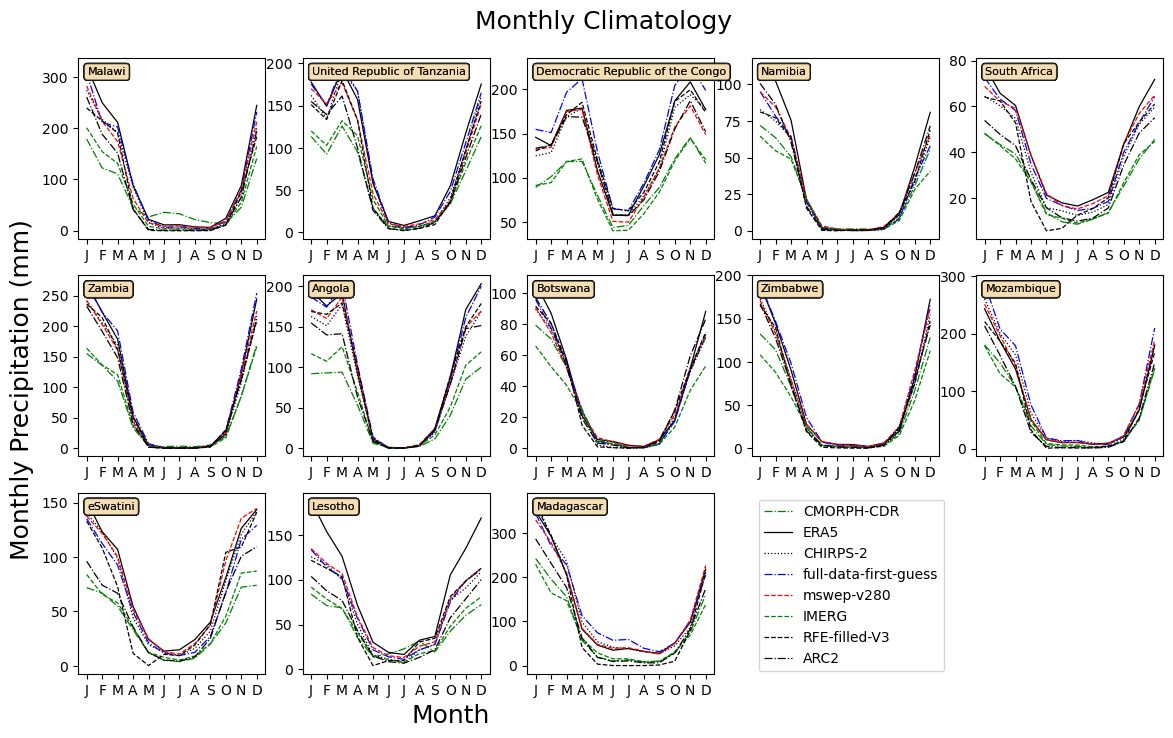

In [30]:
fig=plt.figure(figsize=(14,8))
i=0
countries = to_clip.ADMIN.values

files = glob.glob('data/results/area_averages/*')
year1 = datetime(1991, 1, 1)
year2 = datetime(2020, 12, 31)
for country in countries:
    i=i+1
    ax = plt.subplot(3,5,i)
    print(country)
    #times = rea_1.index
    months = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']

    ltypes_obs=['r--', 'r:', 'r-.', 'r:*']
    ltypes_rea=['k-', 'k:', 'b-.', 'r--', 'g--', 'k--', 'k-.', 'g-.']
    
    datasets = []
    j=-1
    for file in files:
        j=j+1
        #print(file)
        file_split=file.split("/")
        filename=file_split[-1]
        
        filename_base=filename.split(".")[0]
        filename_split=filename_base.split("_")
        #print(filename_base)
        #institute=filename_split[1]  
        dataset=filename_split[1]
        data = xr.open_dataarray(file).isel(region=i-1)
        data_1 = data.sel(time=slice(year1,year2))
        nyears= (year2.year-year1.year)
        data_1 = data_1.groupby('time.month').sum()/nyears
        times = data_1.month
        ax.plot(times,data_1, ltypes_rea[j-1], linewidth=.9, label = dataset)
        ax.set_xticks(range(1,13))
        ax.set_xticklabels(months)   

        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        textstr1 = country
        # place a text box in upper left in axes coords
        ax.text(0.05, 0.95, textstr1, fontsize=8, verticalalignment='top', transform=ax.transAxes, bbox=props)
  
        #all_together = pd.concat([all_together, data], 1)
    
        #altogether[country_all] = copy.deepcopy(all_together)        
plt.legend( bbox_to_anchor=(1.2, 1.0))
plt.suptitle('Monthly Climatology', y =0.94, size = 18)
plt.text(-33,250, 'Monthly Precipitation (mm)', rotation = 90, size = 18)
plt.text(-7,-130, 'Month', size = 18)
#plt.tight_layout()
plt.show()

In [27]:
filename_base

'results_ARC2'

Malawi
United Republic of Tanzania
Democratic Republic of the Congo
Namibia
South Africa
Zambia
Angola
Botswana
Zimbabwe
Mozambique
eSwatini
Lesotho
Madagascar


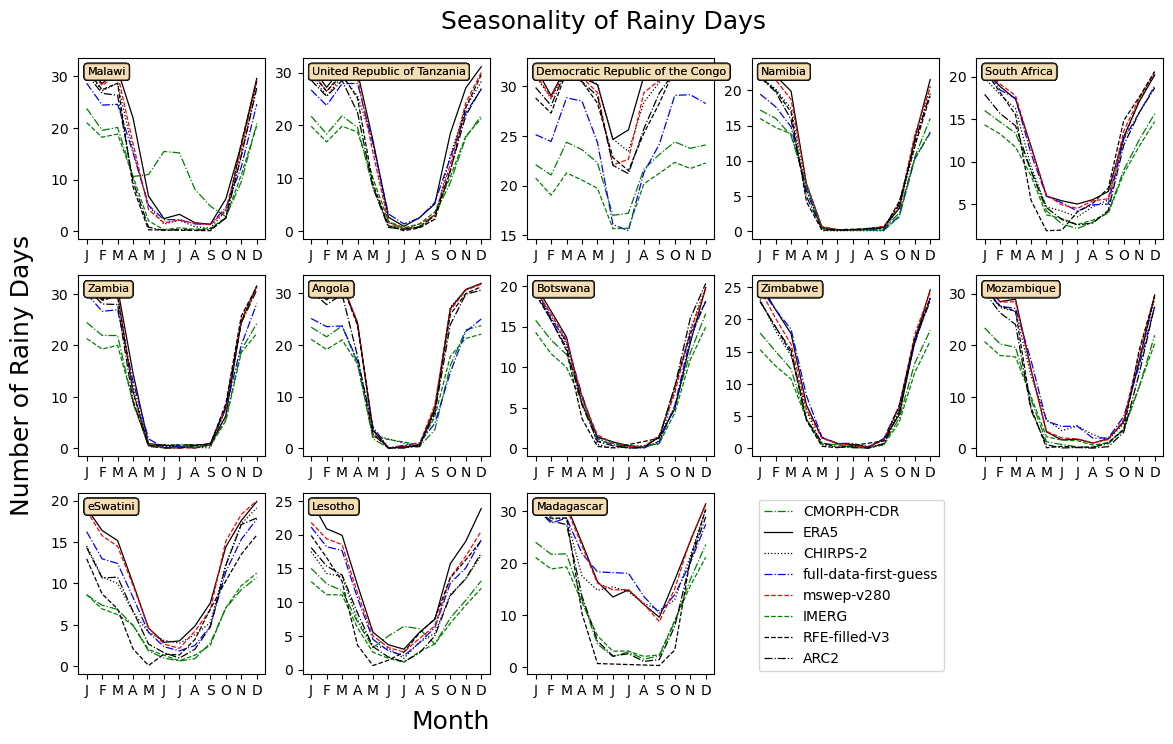

In [31]:
### Number of rainy days

fig=plt.figure(figsize=(14,8))
j=0
#countries = cities_1

year1 = datetime(1991, 1, 1)
year2 = datetime(2020, 12, 31)
i=0
for country in countries:
    i=i+1
    ax = plt.subplot(3,5,i)
    print(country)
    #times = rea_1.index
    months = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']

    ltypes_obs=['r--', 'r:', 'r-.', 'r:*']
    ltypes_rea=['k-', 'k:', 'b-.', 'r--', 'g--', 'k--', 'k-.', 'g-.']
    
    datasets = []
    j=-1
    for file in files:
        j=j+1
        #print(file)
        file_split=file.split("/")
        filename=file_split[-1]
        
        filename_base=filename.split(".")[0]
        filename_split=filename_base.split("_")
        #print(filename_base)
        #institute=filename_split[1]  
        dataset=filename_split[1]
        data = xr.open_dataarray(file).isel(region=i-1)
        data_1 = data.sel(time=slice(year1,year2))
        nyears= (year2.year-year1.year)

        data_1 = data_1[data_1 > 1].groupby('time.month').count()/nyears
        times = data_1.month
        ax.plot(times,data_1, ltypes_rea[j-1], linewidth=.9, label = dataset)
        ax.set_xticks(range(1,13))
        ax.set_xticklabels(months)   

        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        textstr1 = country
        # place a text box in upper left in axes coords
        ax.text(0.05, 0.95, textstr1, fontsize=8, verticalalignment='top', transform=ax.transAxes, bbox=props)
  
        #all_together = pd.concat([all_together, data], 1)
    
        #altogether[country_all] = copy.deepcopy(all_together)        
plt.legend( bbox_to_anchor=(1.2, 1.0))
plt.suptitle('Seasonality of Rainy Days', y =0.94, size = 18)
plt.text(-33,30, 'Number of Rainy Days', rotation = 90, size = 18)
plt.text(-7,-12, 'Month', size = 18)
plt.show()

In [15]:
data_1[data_1 > 1]

<xarray.DataArray 'pr' (time: 4691)>
array([ 2.609472,  4.538327,  2.604737, ...,  5.853487, 18.19433 , 12.087222],
      dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 1998-01-02 1998-01-03 ... 2020-12-31
    spatial_ref  int64 ...
    region       int64 0